In [18]:
import vanilla_vae
import scanpy as sc
import preprocess as pp
from anndata.experimental.pytorch import AnnLoader
import torch
from anndata import AnnData
import numpy as np
import matplotlib.pyplot as plt

In [19]:
dataset = sc.read_h5ad("C:/Users/xbh04/Desktop/b-cells.h5ad")
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'MNP/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'T/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'ABCs']
dataset = pp.regularPreprocess(dataset)
sc.pp.pca(dataset, n_comps=100)
pca = AnnData(dataset.obsm['X_pca'])
pca.obs['Cell_Type'] = np.array(dataset.obs['Manually_curated_celltype'])

train_loader = AnnLoader(pca, batch_size=512, shuffle=True)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
model = vanilla_vae.VanillaVAE(100, 2, [128, 64, 32])
print("Start training VAE...")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(300):
    overall_loss = 0
    for batch in train_loader:
        x = batch.X
        optimizer.zero_grad()
        [x_hat,x, mean, log_var] = model(x)
        loss = model.loss_function(x_hat, x, mean, log_var, M_N=1)
        
        overall_loss += loss['loss']
        
        loss['loss'].backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / 512)
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  tensor(0.8815, grad_fn=<DivBackward0>)
	Epoch 2 complete! 	Average Loss:  tensor(0.8811, grad_fn=<DivBackward0>)
	Epoch 3 complete! 	Average Loss:  tensor(0.8811, grad_fn=<DivBackward0>)
	Epoch 4 complete! 	Average Loss:  tensor(0.8810, grad_fn=<DivBackward0>)
	Epoch 5 complete! 	Average Loss:  tensor(0.8655, grad_fn=<DivBackward0>)
	Epoch 6 complete! 	Average Loss:  tensor(0.8229, grad_fn=<DivBackward0>)
	Epoch 7 complete! 	Average Loss:  tensor(0.8209, grad_fn=<DivBackward0>)
	Epoch 8 complete! 	Average Loss:  tensor(0.8204, grad_fn=<DivBackward0>)
	Epoch 9 complete! 	Average Loss:  tensor(0.8183, grad_fn=<DivBackward0>)
	Epoch 10 complete! 	Average Loss:  tensor(0.8191, grad_fn=<DivBackward0>)
	Epoch 11 complete! 	Average Loss:  tensor(0.8186, grad_fn=<DivBackward0>)
	Epoch 12 complete! 	Average Loss:  tensor(0.8183, grad_fn=<DivBackward0>)
	Epoch 13 complete! 	Average Loss:  tensor(0.8178, grad_fn=<DivBackward0>)
	Epoch 14 co

In [21]:
encoded = model.encode(torch.Tensor(pca.X))
a = []
for i in range(len(encoded[0])):
    a.append(model.reparameterize(encoded[0][i], encoded[1][i]))

GC_B (I)
GC_B (II)
Memory B cells
Naive B cells
Plasma cells
Plasmablasts
Pre-B
Pro-B


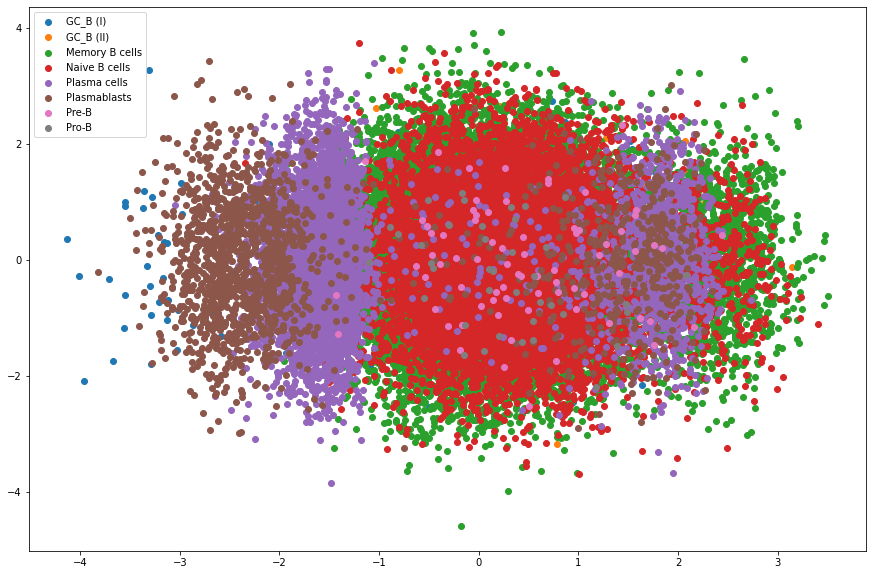

In [22]:
encoded_mean_np = []
for i in range(len(encoded[0])):
    encoded_mean_np.append(np.array(a[i].detach()))
fig, ax = plt.subplots(figsize=(15, 10))
# for color in ["Memory B cells", "Naive B cells"]:
for color in np.unique(np.array(pca.obs['Cell_Type'])):
# for color in ["Memory B cells", "Naive B cells"]:
    print(color)
    i = np.where(pca.obs['Cell_Type'] == color)
    ax.scatter(np.array(encoded_mean_np)[i,0], np.array(encoded_mean_np)[i,1], label=color)
ax.legend()
plt.show()